# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Открытие и изучение файла

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [5]:
df['messages'] = df['messages'].astype('int')

Данные изучены, все типы корректны, тип данных в столбце messages заменен, так как кол-во сообщений может быть только целочисленным

In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


По матрице корелляции видим, что звонки и минуты мультиколлинеарны

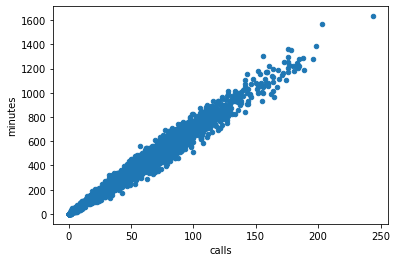

In [7]:
df.loc[:,['calls', 'minutes']].plot(kind='scatter', x='calls', y='minutes')

Исходя из матрицы корелляции и графика можем сделать вывод, что 'minutes' и 'calls' мультиколлинеарны, поэтому для обучения столбец calls можно удалить

In [8]:
df = df.drop('calls', axis=1)

## Разделение данных на выборки

In [9]:
from sklearn.model_selection import train_test_split

Разбиваем датасет на выборки в соотношении 3:1:1 

In [10]:
train_data, valid_test_data = train_test_split(df, test_size=0.4, random_state=12345)

In [11]:
train_data.shape

(1928, 4)

In [12]:
valid_test_data.shape

(1286, 4)

In [13]:
valid_data, test_data = train_test_split(valid_test_data, test_size=0.5, random_state=12345)

In [14]:
test_data.shape

(643, 4)

In [15]:
1928+643+643

3214

In [16]:
def target_features(data):
    features = data.drop('is_ultra', axis=1)
    target = data['is_ultra']
    a = (features, target)
    return a

In [17]:
features_train = target_features(train_data)[0]
target_train = target_features(train_data)[1]

In [18]:
features_valid = target_features(valid_data)[0]
target_valid = target_features(valid_data)[1]

In [19]:
features_test = target_features(test_data)[0]
target_test = target_features(test_data)[1]

Датасет разделен на тестовую, валидационную и тренировочную выборки

## Исследование модели

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Поиск наилучших гипрепараметров для дерева решений

In [21]:
best_result_tree = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth = depth
print('Best accuracy: {}'.format(best_result_tree))
print('Best depth: {}'.format(best_depth))

Best accuracy: 0.7884914463452566
Best depth: 4


Наилучшие результаты и гиперпараметры для дерева решений: Глубина дерева = 4, accuracy = 0.788

Поиск наилучших гиперпараметров для случайного леса

In [22]:
best_result_forest = 0
for depth in range(1, 11):
    for amount in range(2, 11):
        model = RandomForestClassifier(random_state = 12345, max_depth=depth, n_estimators=amount)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result_forest:
            best_result_forest = result
            best_model_forest = model
            best_depth=depth
            best_amount = amount
print('Best accuracy: {}'.format(best_result_forest))
print('Best depth: {}'.format(best_depth))
print('Best amount: {}'.format(best_amount))

Best accuracy: 0.7962674961119751
Best depth: 7
Best amount: 9


Лучшие результаты и гиперпараметры для случайного леса: accuracy = 0.796, глубина=7, количество деревьев = 9

Проверка accuracy для логистической регрессии

In [23]:
model_logistic = LogisticRegression(random_state=12345)
model_logistic.fit(features_train, target_train)
accuracy = model.score(features_valid, target_valid)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.7869362363919129


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


По метрике accuracy наилучшей моделью явлется та, которая работает по алгоритму случайный лес, с максимальной глубиной деревьев 8, и максимальным количеством деревьев 8

## Проверка модели на тестовой выборке

In [24]:
best_model_forest.score(features_test, target_test)

0.8040435458786936

In [25]:
best_model_tree.score(features_test, target_test)

0.7807153965785381

In [26]:
model_logistic.score(features_test, target_test)

0.6982892690513219

Проверка на тестовой выборке показала, что лучшая модель случайного леса самая эффективная

## (бонус) Проверка модели на адекватность

In [27]:
pd.Series(best_model_forest.predict(df.drop('is_ultra', axis=1))).value_counts()

0    2606
1     608
dtype: int64

В целом, на исходных данных сохраняется соотношение для тарифов смарт и ультра

Честно говоря, я не очень понял, что такое проверка модели на вменяемость, оценка качества была произведена в предыдущем задании, поэтому я решил проверить на исходном датасете, объясните, пожалуйста, что такое проверка на вменяемость

Общий вывод: в результате исследования найдена модель, наиболее подходящая для выбора тарифа. Это модель работающая на алгоритме случайного леса, результаты работы этой модели: accuracy(на валидационной выборке) = 0.796, accuracy(на тестовой выборке) = 0.8, результаты метрики почти совпадают, причем они достаточно высокие, это говорит о том, что удалось избежать проблем переобучения и недообучения, гиперпараметры этой модели: максимальная глубина деревьев=7, максимальное количество деревьев=9.
Модель сравнивалась и с другими.
Среди моделей, работающих на алгоритме решающего дерева, лучшей оказалась та, у которой глубина дерева = 4, accuracy этой модели=0.79(на валидационной выборке) и 0.78(на тестовой выборке). Так же была протестирована модель, работающая на алгоритме логистической регрессии, ее accuracy = 0.79(на валидационной выборке) и 0.69(на тестовой выборке).